# Ascensions
In this notebook the data for peak ascensions is scraped and processed.

In [1]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd
import re

## Geting total ascensions
Total ascensions are scraped from the main page of each peak.

In [13]:
with open("centcims.json", encoding="utf-8") as f:
    cent_cims = json.load(f)

In [ ]:
ascensions = []

In [22]:
for i, cim in enumerate(cent_cims):
    if i > 322:
        r = requests.get(cim["url"]["feec"]).text
        soup = BeautifulSoup(r, "html.parser")

        ascensio = int(soup.select(
            f"#post-{cim['id']} > header > div > div > div.col-lg-5.bg-primari.white.p-md-5.p-4.d-flex.flex-column > h4.fw-bold.fs-20.mb-2")[
                           0].text.split()[0])

        ascensions.append({"peak": cim["name"], "ascensions": ascensio})
        print(f"{(i + 1) / len(cent_cims) * 100:.2f} % - {cim['name']}: {ascensio}")

62.07 % - Punta Senyalada: 7
62.26 % - Pic de Contraix: 7
62.45 % - Tuc des Carants: 32
62.64 % - Roca del Coscolló: 22
62.84 % - Roca de Migdia (Serra del Verd): 23
63.03 % - Turó Punçó: 54
63.22 % - Pic de Costa Cabirolera: 109
63.41 % - Tossal de Lletó: 13
63.60 % - Roc de Cogul: 44
63.79 % - Cap de Pla Redon: 7
63.98 % - Tossal de Badés: 28
64.18 % - Roc Roi: 16
64.37 % - Serrat de Carrasquers: 12
64.56 % - l\'Oratori: 12
64.75 % - Penya Aguda: 10
64.94 % - Sant Quiri: 23
65.13 % - Roc de les Tres Creus: 28
65.33 % - Tossal de Balinyó: 38
65.52 % - Puig dels Pruners: 27
65.71 % - Puig d\'en Jordà: 29
65.90 % - Puig de Cervera: 58
66.09 % - Tossa d\'Espinau: 47
66.28 % - Puig Segalar: 59
66.48 % - Puig Falcó: 27
66.67 % - Santa Magdalena: 52
66.86 % - Puig de l\'Àliga (Cap de Creus): 94
67.05 % - Puig dels Bufadors: 38
67.24 % - Tossal Bovinar: 42
67.43 % - Tossal de la Truita (Pic de Perafita): 136
67.62 % - Pic de l\'Estanyó: 67
67.82 % - Puig de Coma d\'Or: 64
68.01 % - Besiberri

In [26]:
with open("ascensions.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(ascensions, ensure_ascii=False, indent=4))

<AxesSubplot:>

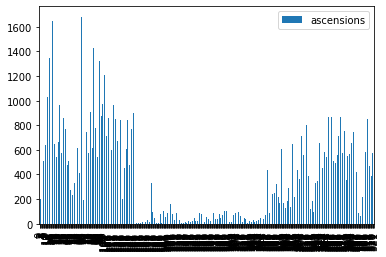

In [41]:
ascensions_df = pd.read_json("ascensions.json")
ascensions_df.plot.bar()

In [42]:
ascensions_df.mean()

C:\Users\jayma\AppData\Local\Temp/ipykernel_18504/2295290973.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ascensions_df.mean()


ascensions    379.549808
dtype: float64

## Detall d'ascensions
Les ascensions individuals (amb nom i data) es descarreguen simulant la crida ajax (POST) que fa la web de 100 cims. Ajax fa servir un *nonce* (*number once*), un identificador únic amb un temps de vida limitat com a mesura de seguretat. El *nonce* s'extreu del contingut d'una de les etiquetes `<script>` de l'HTML de la pàgina, que té `id=AjaxCustom-js-extra`.

In [12]:
with open("ascensions.json", encoding="utf-8") as f:
    ascensions = json.load(f)

In [45]:
def find_nonce(url):
    r = requests.get(url).text

    soup = BeautifulSoup(r, "html.parser")
    script = soup.find("script", {"type": "text/javascript", "id": "AjaxCustom-js-extra"})

    return json.loads(re.search(r"{.+}", script.string).group(0))["nonce"]


def retrieve_ascensions(id, nonce):
    data = {
        'action': 'get_ascensos_users',
        'nonce': nonce,
        'cim_id': id,
    }
    return requests.post('https://www.feec.cat/wp-admin/admin-ajax.php', data=data).text

Es fa servir un *nonce* únic per totes les crides. Si una de les iteracions falla, es busca un nou *nonce* i es torna a provar. No sé quin és el temps de vida de cada *nonce* però això no ha fet falta en cap execució de la cel·la, deu ser d'un dia o d'unes hores com a mínim.

In [47]:
%%time
for i, cim in enumerate(cent_cims):
    if i == 0:
        nonce = find_nonce(cim["url"]["feec"])

    response = retrieve_ascensions(cim["id"], nonce)
    if response == "\r\nWrong nonce!":
        print(f"Nonce failed for {cim['name']}. Retrying...")
        nonce = find_nonce(cim["url"]["feec"])
        response = retrieve_ascensions(cim["id"], nonce)

    ascensions[i]["total"] = json.loads(pd.read_html("<table>" + response + "</table>")[0].rename(
        columns={0: "user", 1: "date"}).to_json(orient="records", force_ascii=False))

    print(f"{(i + 1) / len(cent_cims) * 100:.2f} % ({i + 1}/{len(cent_cims)}) - {cim['name']}")

0.19 % (1/522) - El Cogulló de Cabra
0.38 % (2/522) - Puig de Tretzevents
0.57 % (3/522) - Torre de Madeloc
0.77 % (4/522) - Cambra d\'Ase
0.96 % (5/522) - Canigó
1.15 % (6/522) - Carlit
1.34 % (7/522) - Puig Peric
1.53 % (8/522) - Roc de Madres
1.72 % (9/522) - Torre d\'Eina
1.92 % (10/522) - Casamanya Nord
2.11 % (11/522) - Comapedrosa
2.30 % (12/522) - Pic de la Serrera
2.49 % (13/522) - Pic del Vent
2.68 % (14/522) - Pic Negre d\'Envalira
2.87 % (15/522) - Sant Sadurní de Gallifa
3.07 % (16/522) - Tagamanent
3.26 % (17/522) - Tristaina
3.45 % (18/522) - Puigmal
3.64 % (19/522) - Castellsapera
3.83 % (20/522) - El Cogul
4.02 % (21/522) - La Mola de Sant Llorenç del Munt
4.21 % (22/522) - Les Agudes
4.41 % (23/522) - Maubèrme
4.60 % (24/522) - Montardo
4.79 % (25/522) - Montcorbison
4.98 % (26/522) - Montlude
5.17 % (27/522) - Punta de Montmeneu
5.36 % (28/522) - Pilar d\'Almenara
5.56 % (29/522) - Puig de la Creu
5.75 % (30/522) - Puig de les Morreres
5.94 % (31/522) - Roques de Ben

El JSON generat està defectuós, perquè les dades de les ascensions s'han enganxat com a string. Ho he solucionat manualment reemplaçant `"["` i `"]"` per `[` i `[`, i eliminant `\`. Seria millor fer-ho des del codi però no ho he fet. **DIRIA QUE JA ESTÀ ARREGLAT** però no ho he comprovat.

In [ ]:
with open("ascensions.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(ascensions, ensure_ascii=False, indent=4))

## Processat de les ascensions
S'agrupen les ascensions per mesos per fer servir les dades per dibuixar les dades d'estacionalitat.

In [86]:
with open("ascensions.json", encoding="utf-8") as f:
    ascensions = json.load(f)

In [104]:
asc_df = pd.DataFrame(ascensions[7]["total"])
asc_df

,user,date
0,Toni Crous Casals,14-06-2008
1,Pilar Florenza Garcia,01-08-2010
2,Xavier Bermudez Yebra,10-08-2010
3,Anna Mª Sanchez Carrera,10-08-2010
4,Pere Serrats Garnatxe,10-08-2010
...,...,...
324,Manel Sorolla Oliva,09-10-2022
325,M. Montserrat Bergadà Granyó,09-10-2022
326,Marta Del Ruste Carrera,12-09-2020
327,Andreu Perez Garcia,19-09-0021


In [128]:
asc_df["date"] = pd.to_datetime(asc_df["date"], format="%d-%m-%Y", errors="coerce")
json.loads(asc_df.groupby(asc_df.date.dt.month)["user"].agg("count").to_json())
month = asc_df.groupby(asc_df.date.dt.month)["user"].agg("count")
month.index = month.index.astype(int)
json.loads(month.to_json())

{'1': 15,
 '2': 23,
 '3': 18,
 '4': 10,
 '5': 14,
 '6': 48,
 '7': 29,
 '8': 59,
 '9': 54,
 '10': 38,
 '11': 6,
 '12': 14}

In [129]:
%%time
for i, cim in enumerate(cent_cims):
    df = pd.DataFrame(ascensions[i]["total"])
    df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")
    month = df.groupby(df.date.dt.month)["user"].agg("count")
    month.index = month.index.astype(int)

    cim["ascensions"] = {
        "total": ascensions[i]["ascensions"],
        "monthly": json.loads(month.to_json())
    }
    print(f"{i + 1}/{len(cent_cims)} - {cim['name']}")

cent_cims

1/522 - El Cogulló de Cabra
2/522 - Puig de Tretzevents
3/522 - Torre de Madeloc
4/522 - Cambra d\'Ase
5/522 - Canigó
6/522 - Carlit
7/522 - Puig Peric
8/522 - Roc de Madres
9/522 - Torre d\'Eina
10/522 - Casamanya Nord
11/522 - Comapedrosa
12/522 - Pic de la Serrera
13/522 - Pic del Vent
14/522 - Pic Negre d\'Envalira
15/522 - Sant Sadurní de Gallifa
16/522 - Tagamanent
17/522 - Tristaina
18/522 - Puigmal
19/522 - Castellsapera
20/522 - El Cogul
21/522 - La Mola de Sant Llorenç del Munt
22/522 - Les Agudes
23/522 - Maubèrme
24/522 - Montardo
25/522 - Montcorbison
26/522 - Montlude
27/522 - Punta de Montmeneu
28/522 - Pilar d\'Almenara
29/522 - Puig de la Creu
30/522 - Puig de les Morreres
31/522 - Roques de Benet (el Castell)
32/522 - Sant Miquel de Solterra
33/522 - Santa Bàrbara
34/522 - Taga
35/522 - Tossal de la Creu
36/522 - Tuc de Molières
37/522 - Tuc deth Port de Vielha
38/522 - Turó de Montsoriu
39/522 - Balandrau
40/522 - Bastiments
41/522 - Costa Pubilla o Pla de Pujalts
42

[{'name': 'El Cogulló de Cabra',
  'id': 639,
  'coords': {'latlng': {'lat': 41.4290355033, 'lng': 1.3057579489},
   'utm': {'x': 358437, 'y': 4587771}},
  'topography': {'territory': [{'name': 'Catalunya', 'id': 'CAT'}],
   'vegueria': [{'name': 'Camp', 'id': 3}],
   'comarca': [{'name': 'Alt Camp', 'id': 1}]},
  'essential': True,
  'url': {'feec': 'https://www.feec.cat/activitats/100-cims/cim/el-cogullo-de-cabra/',
   'wikidata': 'http://www.wikidata.org/entity/Q17481698',
   'wikipedia': 'https://ca.wikipedia.org/wiki/El_Cogull%C3%B3_(el_Pont_d%27Armentera)'},
  'images': ['https://upload.wikimedia.org/wikipedia/commons/b/bd/El_Cogull%C3%B3_des_de_Montblanc_P1250216.jpg'],
  'height': 881,
  'summary': "El Cogulló és una muntanya de 881 metres que es troba al municipi del Pont d'Armentera, a la comarca de l'Alt Camp.",
  'ascensions': {'total': 727,
   'monthly': {'1': 94,
    '2': 98,
    '3': 64,
    '4': 98,
    '5': 53,
    '6': 36,
    '7': 21,
    '8': 29,
    '9': 43,
    

In [130]:
with open("centcims.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(cent_cims, ensure_ascii=False, indent=4))